In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotting
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split
import datapreprocessing as dp

# Plots 

In [2]:
def parameter_plot(df, model='', parameter=''):
    fig = plt.figure()
    ax = sns.scatterplot(df.T.groupby('best_param').count().index.values , df.T.groupby('best_param').count()['mean_test_r2'])
    print('Average: {} ({})'.format(np.mean(df.loc['best_param']), 
                                    round(np.std(df.loc['best_param']),4)))
    ax.axhline(0)
    ax.set_title(model+': Parameter Distribution across all targets')
    ax.set_xlabel(parameter)
    return fig

In [3]:
def cv_plot(df, model='', parameter='', score='mean_test_r2'):
    fig = plt.figure()
    for t in df.columns.get_level_values(0).drop_duplicates():
        ax = sns.lineplot(x=df[t].params, y=df[t][score])
    
    # figure out how to print best param. / average out. 
    #print('Average: {} ({})'.format(np.mean(df.loc['best_param']), 
                                    #np.std(df.loc['best_param'])))
    ax.set_title('Parameter Distribution: '+model+parameter)
    ax.set_xlabel(parameter)
    return fig

In [4]:
# looking at one CV case
def cv_single(df, score, best_param, name, param='param_alpha'):
    fig = plt.figure()
    splits = [col for col in df.columns if (score in col) & ('split' in col)]
    plt.plot(df[param],df[splits])
    plt.plot(df[param],df['mean_'+score], label='mean', c = 'black')
    plt.axvline(best_param, linestyle='--', color='k',
                label='CV estimate: alpha='+str(best_param))
    plt.legend()
    plt.xlabel('alpha')
    plt.ylabel(score)
    plt.title(name+' CV')
    return fig

In [5]:
def parameter_r2_plot(df, model='', parameter='', feature='best_param'):
    fig = plt.figure()
    ax = sns.scatterplot(x = df.loc[feature], y=df.loc['mean_test_r2'])
    ax.set_title('{}: R2 value against best {} for all targets'.format(model, parameter))
    ax.set_xlabel(parameter)
    ax.set_ylabel('mean test R2')
    print('Average {}: {} ({})'.format(parameter, np.mean(df.loc[feature]), 
                                    round(np.std(df.loc[feature]), 4)))
    #print('Average R2 for max_depth 30: {}'.format(df.loc[:,df.loc[feature]==30].loc['mean_test_r2'].mean()))
    #print('Average R2 for max_depth 40: {}'.format(df.loc[:,df.loc[feature]==40].loc['mean_test_r2'].mean()))
    return fig

In [6]:
def parameter_r2_violin(df, model='', parameter='', feature='best_param'):
    fig = plt.figure()
    ax = sns.violinplot(x = round(df.loc[feature],5), y=df.loc['mean_test_r2'], scale='width')

    ax.set_title('{}: R2 value against best {} for all targets'.format(model, parameter))
    ax.set_xlabel(parameter)
    ax.set_ylabel('mean test R2')
    print('Average {}: {} ({})'.format(parameter, np.mean(df.loc[feature]), 
                                    round(np.std(df.loc[feature]), 4)))
    #print('Average R2 for max_depth 30: {}'.format(df.loc[:,df.loc[feature]==30].loc['mean_test_r2'].mean()))
    #print('Average R2 for max_depth 40: {}'.format(df.loc[:,df.loc[feature]==40].loc['mean_test_r2'].mean()))
    return fig

In [7]:
def r2_plot(df, model='', parameter='params'):
    fig = plt.figure()
    ax = sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_test_r2']].mean(axis=1), 
                      x=df[('Mcm3', parameter)], label='Test R2')
    sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_train_r2']].mean(axis=1), 
                 x=df[('Mcm3', parameter)], label='Train R2')
    ax.fill_between(df[('Mcm3', parameter)].tolist(), 
                    (df[[idx for idx in df.columns if idx[1]=='mean_test_r2']].mean(axis=1) + df[[idx for idx in df.columns if idx[1]=='mean_test_r2']].std(axis=1)).tolist(),
                    (df[[idx for idx in df.columns if idx[1]=='mean_test_r2']].mean(axis=1) - df[[idx for idx in df.columns if idx[1]=='mean_test_r2']].std(axis=1)).tolist(), 
                    alpha=0.2) 
    idx = plotting.best_overall_index(df)
    plt.axvline(df[('Mcm3','params')][idx], linestyle='--', color='k',
                label='CV estimate: alpha='+str(round(df[('Mcm3','params')][idx], 4)))
    ax.legend()
    ax.set_title(model+': mean R2 values for alphas')
    ax.set_xlabel('alpha')
    ax.set_ylabel('mean R2 value')
    return fig

In [8]:
def r2_multi_plot(df, model='', parameter='params'):
    fig = plt.figure()
    plt.plot(df[('Mcm3', parameter)], df[[idx for idx in df.columns if idx[1]=='mean_test_r2']], c='cornflowerblue', alpha=0.1)
    ax = sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_test_r2']].mean(axis=1), 
                          x=df[('Mcm3', parameter)], label='Test R2')
    sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_train_r2']].mean(axis=1), 
                     x=df[('Mcm3', parameter)], label='Train R2')
    idx = plotting.best_overall_index(df)
    plt.axvline(df[('Mcm3','params')][idx], linestyle='--', color='k',
                    label='CV estimate: alpha='+str(round(df[('Mcm3','params')][idx], 4)), alpha=0.6)
    ax.set_title(model+': R2 values across all parameters for all models')
    ax.set_xlabel('alpha')
    ax.set_ylabel('mean R2 value')
    ax.set_xlim(0.006)
    return fig

In [9]:
def r2_plot_simple(df, model='', parameter='params'):
    fig = plt.figure()
    ax = sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_test_r2']].mean(axis=1), x=df[('Mcm3', parameter)], label='Test R2')
    ax.legend()
    ax.set_title(model+': mean R2 values for alphas')
    ax.set_xlabel('alpha')
    ax.set_ylabel('mean R2 value')
    return fig

In [10]:
def mse_plot_simple(df, model='', parameter='params'):
    fig = plt.figure()
    ax = sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_test_neg_mean_squared_error']].mean(axis=1)*-1, x=df[('Mcm3', 'params')], label='Test MSE')
    ax.legend()
    ax.set_title(model+': mean MSE values for alphas')
    ax.set_xlabel('alpha')
    ax.set_ylabel('mean MSE value') 
    return fig

In [11]:
def mse_plot(df, model=''):
    fig = plt.figure()
    ax = sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_test_neg_mean_squared_error']].mean(axis=1)*-1, x=df[('Mcm3', 'params')], label='Test MSE')
    sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_train_neg_mean_squared_error']].mean(axis=1)*-1, x=df[('Mcm3', 'params')], label='Train MSE')
    ax.fill_between(df[('Mcm3', parameter)].tolist(), 
                    (df[[idx for idx in df.columns if idx[1]=='mean_test_neg_mean_squared_error']].mean(axis=1)*-1 + df[[idx for idx in df.columns if idx[1]=='mean_test_neg_mean_squared_error']].std(axis=1)*-1).tolist(),
                    (df[[idx for idx in df.columns if idx[1]=='mean_test_neg_mean_squared_error']].mean(axis=1)*-1 - df[[idx for idx in df.columns if idx[1]=='mean_test_neg_mean_squared_error']].std(axis=1)*-1).tolist(), 
                    alpha=0.2)
    idx = plotting.best_overall_index(df)
    plt.axvline(df[('Mcm3','params')][idx], linestyle='--', color='k',
                label='CV estimate: alpha='+str(round(df[('Mcm3','params')][idx], 4)), alpha=0.6)
    ax.legend()
    ax.set_title(model+': mean MSE values for alphas')
    ax.set_xlabel('alpha')
    ax.set_ylabel('mean MSE value')
    return fig

In [12]:
pred, X, velocity_genes, y = dp.get_data(louvain=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y['louvain'], test_size = 0.25, shuffle=True, random_state=42)

pred, X, velocity_genes, y = dp.get_data(predictors='velocity_genes', louvain=True)
X_train_1109, X_test_1109, y_train_1109, y_test_1109 = train_test_split(X, y, stratify=y['louvain'], test_size = 0.25, shuffle=True, random_state=42)

/home/ubuntu/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ubuntu/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


# Lasso 160

In [13]:
# import models
path = './model_selection/Lasso(random_state=42)/'

lasso, best_lasso = plotting.compile_gridsearches_lin(path)

ldf_160 = pd.DataFrame(plotting.reform(lasso))
best_ldf_160 = pd.DataFrame(best_lasso)

In [14]:
# settings
best = best_ldf_160
full = ldf_160
name = 'Lasso'
parameter = 'params'
model = Lasso()

In [15]:
#coutn how many have optimum as best vlaue. 
best_ldf_160.transpose()[best_ldf_160.transpose()['best_param']<0.0004]

,best_param,mean_test_r2,mean_train_r2,mean_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_test_neg_mean_squared_error,std_train_neg_mean_squared_error,std_test_r2,std_train_r2
Malat1,0.000358,0.878199,0.907319,-0.121521,-0.092723,0.007441,0.000626,0.010282,0.000845


In [16]:
best_ldf_160

,1700019D03Rik,Cd55,Aff3,Fhl2,Actr3,Ikzf2,Bcl2,Mrpl15,Tmem163,Ikbke,...,Pola1,Prdx4,Maoa,Kif4,Utp14a,Dkc1,Cenpi,Gpm6b,Smc1a,Erdr1
best_param,0.001446,0.001446,0.000720,0.001446,0.001446,0.001446,0.001446,0.001446,0.001446,0.001446,...,0.000720,0.001446,0.001446,0.001446,0.001446,0.001446,0.001446,0.001446,0.001446,0.000720
mean_test_r2,0.249092,0.347906,0.570939,0.314495,0.535389,0.387167,0.325718,0.315703,0.368988,0.365760,...,0.661107,0.405603,0.290940,0.515647,0.290067,0.433145,0.547284,0.365947,0.437377,0.689092
mean_train_r2,0.420001,0.480905,0.670850,0.441386,0.619682,0.509668,0.465849,0.440991,0.483987,0.492954,...,0.729821,0.512586,0.431911,0.611260,0.427043,0.541071,0.629501,0.497270,0.540612,0.754509
mean_test_neg_mean_squared_error,-0.775749,-0.627882,-0.437661,-0.697696,-0.458036,-0.621032,-0.687567,-0.677919,-0.630625,-0.648347,...,-0.336358,-0.590527,-0.676550,-0.480238,-0.709388,-0.563399,-0.442996,-0.636498,-0.562959,-0.307098
mean_train_neg_mean_squared_error,-0.603209,-0.507508,-0.336173,-0.569037,-0.375305,-0.498576,-0.545363,-0.555007,-0.516106,-0.519637,...,-0.268797,-0.487068,-0.552478,-0.387225,-0.573404,-0.459211,-0.363347,-0.504732,-0.460536,-0.243037
std_test_neg_mean_squared_error,0.161160,0.045222,0.048899,0.056919,0.015947,0.034496,0.060327,0.029107,0.040240,0.032728,...,0.019849,0.034340,0.064358,0.047852,0.037062,0.041721,0.034101,0.076367,0.022920,0.016296
std_train_neg_mean_squared_error,0.013965,0.004228,0.004442,0.005683,0.001491,0.002752,0.006038,0.002901,0.004209,0.002722,...,0.001838,0.002957,0.005744,0.003782,0.003278,0.004164,0.002498,0.007301,0.002235,0.001508
std_test_r2,0.053443,0.064318,0.038126,0.028517,0.013287,0.031116,0.025436,0.031851,0.025833,0.028566,...,0.023346,0.041995,0.086630,0.037248,0.016943,0.047848,0.023524,0.036614,0.026321,0.019894
std_train_r2,0.004594,0.007173,0.003087,0.003282,0.001447,0.002998,0.002715,0.003162,0.002654,0.002570,...,0.002209,0.004140,0.008261,0.003478,0.001631,0.004272,0.002270,0.003534,0.002530,0.001954


<AxesSubplot:xlabel="('Mcm3', 'params')">

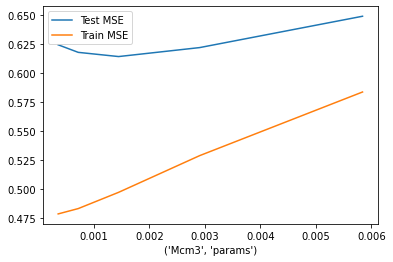

In [17]:
sns.lineplot(y=ldf_160[[idx for idx in ldf_160.columns if idx[1]=='mean_test_neg_mean_squared_error']][-5:].mean(axis=1)*-1, x=ldf_160[('Mcm3', 'params')][-5:], label='Test MSE')
sns.lineplot(y=ldf_160[[idx for idx in ldf_160.columns if idx[1]=='mean_train_neg_mean_squared_error']][-5:].mean(axis=1)*-1, x=ldf_160[('Mcm3', 'params')][-5:], label='Train MSE')

<AxesSubplot:xlabel="('Mcm3', 'params')">

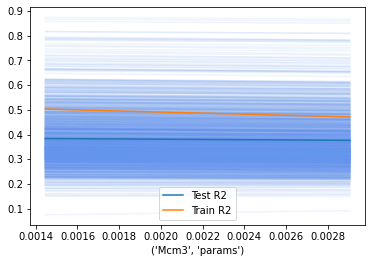

In [18]:
df = ldf_160

plt.plot(df[('Mcm3', parameter)][-4:-2], df[[idx for idx in df.columns if idx[1]=='mean_test_r2']][-4:-2], c='cornflowerblue', alpha=0.1)
ax = sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_test_r2']][-4:-2].mean(axis=1), 
                          x=df[('Mcm3', parameter)][-4:-2], label='Test R2')
sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_train_r2']][-4:-2].mean(axis=1), 
                     x=df[('Mcm3', parameter)][-4:-2], label='Train R2')

Average params: 0.0014239362143850314 (0.0003)
Average params: 0.0014239362143850314 (0.0003)
Average: 0.0014239362143850314 (0.0003)


/home/ubuntu/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


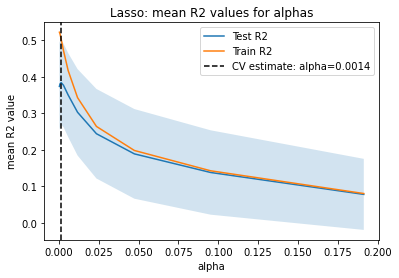

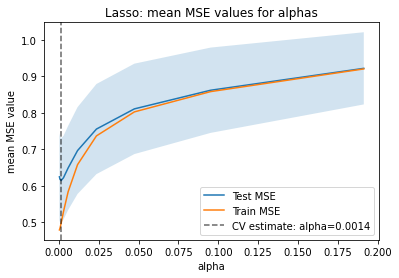

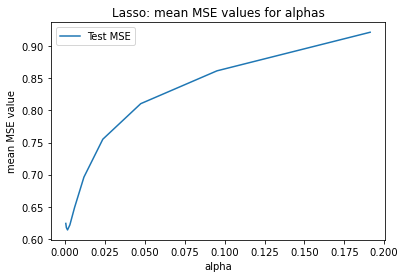

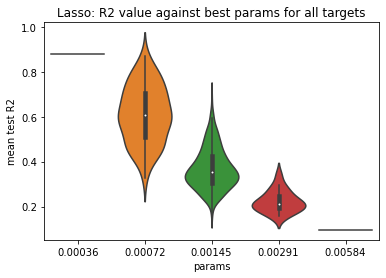

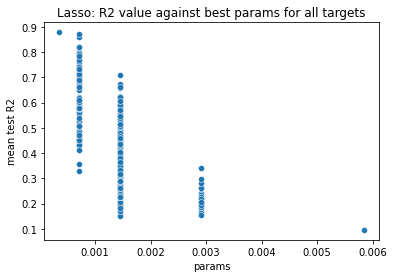

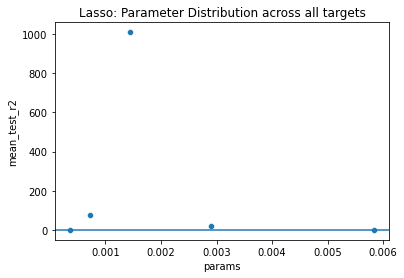

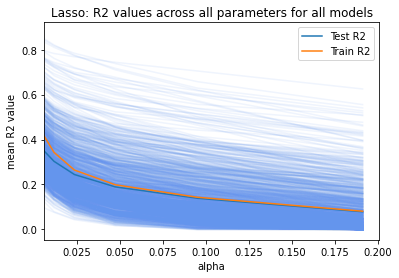

In [19]:
# plots
r2_plot(full, model=name, parameter = parameter).savefig(path+'plots/r2_plot.png')
mse_plot(full, model=name).savefig(path+'plots/mse_plot.png')
mse_plot_simple(full, model=name, parameter=parameter).savefig(path+'plots/mse_plot_simple.png')
parameter_r2_violin(best, model=name, parameter=parameter, feature='best_param').savefig(path+'plots/parameter_r2_violin.png')
parameter_r2_plot(best, model=name, parameter=parameter, feature='best_param').savefig(path+'plots/parameter_r2.png')
parameter_plot(best, model=name, parameter=parameter).savefig(path+'plots/parameter_plot.png')
r2_multi_plot(full, model=name, parameter = parameter).savefig(path+'plots/r2_multi_plot.png')

complete


/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 112.4512939453125, tolerance: 1.0338935852050781
  model = cd_fast.enet_coordinate_descent(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117.384765625, tolerance: 1.0448572635650635
  model = cd_fast.enet_coordinate_descent(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 405.946533203125, tolerance: 1.0119308233261108
  model = cd_fast.enet_coordinate_descent(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

KeyboardInterrupt: 

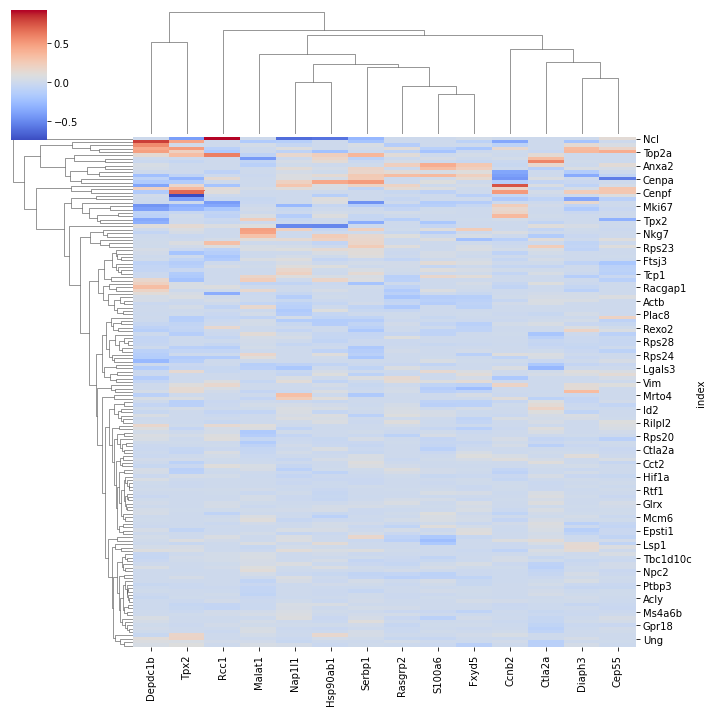

In [20]:
# clustering
print('complete')
gridc = plotting.cluster_overall(model, full, X_train, y_train, path+'plots/')
plotting.cluster_individual(model, best, X_train, y_train, path+'plots/')
print('single')
gridc = plotting.cluster_overall(model, full, X_train, y_train, path+'plots/', clustering='single')
grida = plotting.cluster_individual(model, best, X_train, y_train, path+'plots/', clustering='single')

plotting.cluster_individual(model, best, X_train, y_train, path+'plots/', clustering='ward')
gridc = plotting.cluster_overall(model, full, X_train, y_train, path+'plots/', clustering='ward')
gridc = plotting.cluster_overall(model, full, X_train, y_train, path+'plots/', clustering='single')

# Lasso 1109

In [ ]:
# import models
path = './model_selection/vpred/Lasso(random_state=42)/'

lasso, best_lasso = plotting.compile_gridsearches_lin(path)

ldf_1109 = pd.DataFrame(plotting.reform(lasso))
best_ldf_1109 = pd.DataFrame(best_lasso)

In [ ]:
# settings
best = best_ldf_1109
full = ldf_1109
name = 'Lasso'
parameter = 'params'
model = Lasso()

In [ ]:
# plots
r2_plot(full, model=name, parameter = parameter).savefig(path+'plots/r2_plot.png')
mse_plot(full, model=name).savefig(path+'plots/mse_plot.png')
mse_plot_simple(full, model=name, parameter=parameter).savefig(path+'plots/mse_plot_simple.png')
parameter_r2_violin(best, model=name, parameter=parameter, feature='best_param').savefig(path+'plots/parameter_r2_violin.png')
parameter_r2_plot(best, model=name, parameter=parameter, feature='best_param').savefig(path+'plots/parameter_r2.png')
parameter_plot(best, model=name, parameter=parameter).savefig(path+'plots/parameter_plot.png')
r2_multi_plot(full, model=name, parameter = parameter).savefig(path+'plots/r2_multi_plot.png')

In [ ]:
# clustering
gridc = plotting.cluster_overall(model, full, X_train_1109, y_train_1109, path+'plots/')
grida = plotting.cluster_individual(model, best, X_train_1109, y_train_1109, path+'plots/', clustering='single')
plotting.cluster_individual(model, best, X_train_1109, y_train_1109, path+'plots/')
plotting.cluster_individual(model, best, X_train_1109, y_train_1109, path+'plots/', clustering='ward')
gridc = plotting.cluster_overall(model, full, X_train_1109, y_train_1109, path+'plots/', clustering='ward')
gridc = plotting.cluster_overall(model, full, X_train_1109, y_train_1109, path+'plots/', clustering='single')

In [ ]:
a =plotting.cluster_overall(Lasso(), ldf_1109, X_train, y_train, path+'plots/')

In [ ]:
a.data

# Ridge 160

In [ ]:
# import models
path = './model_selection/Ridge(random_state=42)/'

ridge, best_ridge = plotting.compile_gridsearches_lin(path)

rdf_160 = pd.DataFrame(plotting.reform(ridge))
best_rdf_160 = pd.DataFrame(best_ridge)

In [ ]:
# settings
best = best_rdf_160
full = rdf_160
name = 'Ridge'
parameter = 'params'
model = Ridge()

In [ ]:
# plots
r2_plot(full, model=name, parameter = parameter).savefig(path+'plots/r2_plot.png')
mse_plot(full, model=name).savefig(path+'plots/mse_plot.png')
mse_plot_simple(full, model=name, parameter=parameter).savefig(path+'plots/mse_plot_simple.png')
parameter_r2_violin(best, model=name, parameter=parameter, feature='best_param').savefig(path+'plots/parameter_r2_violin.png')
parameter_r2_plot(best, model=name, parameter=parameter, feature='best_param').savefig(path+'plots/parameter_r2.png')
parameter_plot(best, model=name, parameter=parameter).savefig(path+'plots/parameter_plot.png')
r2_multi_plot(full, model=name, parameter = parameter).savefig(path+'plots/r2_multi_plot.png')

In [ ]:
# clustering
gridc = plotting.cluster_overall(model, full, X_train, y_train, path+'plots/')
grida = plotting.cluster_individual(model, best, X_train, y_train, path+'plots/', clustering='single')
plotting.cluster_individual(model, best, X_train, y_train, path+'plots/')
plotting.cluster_individual(model, best, X_train, y_train, path+'plots/', clustering='ward')
gridc = plotting.cluster_overall(model, full, X_train, y_train, path+'plots/', clustering='ward')
gridc = plotting.cluster_overall(model, full, X_train, y_train, path+'plots/', clustering='single')

# Ridge 1109

In [ ]:
# import models
path = './model_selection/vpred/Ridge(random_state=42)/'

ridge, best_ridge = plotting.compile_gridsearches_lin(path)

rdf_1109 = pd.DataFrame(plotting.reform(ridge))
best_rdf_1109 = pd.DataFrame(best_ridge)

In [ ]:
# settings
best = best_rdf_1109
full = rdf_1109
name = 'Ridge'
parameter = 'params'
model = Ridge()

In [ ]:
# plots
r2_plot(full, model=name, parameter = parameter).savefig(path+'plots/r2_plot.png')
mse_plot(full, model=name).savefig(path+'plots/mse_plot.png')
mse_plot_simple(full, model=name, parameter=parameter).savefig(path+'plots/mse_plot_simple.png')
parameter_r2_violin(best, model=name, parameter=parameter, feature='best_param').savefig(path+'plots/parameter_r2_violin.png')
parameter_r2_plot(best, model=name, parameter=parameter, feature='best_param').savefig(path+'plots/parameter_r2.png')
parameter_plot(best, model=name, parameter=parameter).savefig(path+'plots/parameter_plot.png')
r2_multi_plot(full, model=name, parameter = parameter).savefig(path+'plots/r2_multi_plot.png')

In [ ]:
# clustering
gridc = plotting.cluster_overall(model, full, X_train_1109, y_train_1109, path+'plots/')
grida = plotting.cluster_individual(model, best, X_train_1109, y_train_1109, path+'plots/', clustering='single')
plotting.cluster_individual(model, best, X_train_1109, y_train_1109, path+'plots/')
plotting.cluster_individual(model, best, X_train_1109, y_train_1109, path+'plots/', clustering='ward')
gridc = plotting.cluster_overall(model, full, X_train_1109, y_train_1109, path+'plots/', clustering='ward')
gridc = plotting.cluster_overall(model, full, X_train_1109, y_train_1109, path+'plots/', clustering='single')

# Linear 160

In [21]:
# import models
path = './model_selection/LinearRegression()/'

lin, best_lin = plotting.compile_gridsearches_lin(path, lin = True)

lindf_160 = pd.DataFrame(plotting.reform(lin))
best_lindf_160 = pd.DataFrame(best_lin)

In [ ]:
# I dont think plots make sense here. Just to compare. And clusters also do not make sens. nothing here.

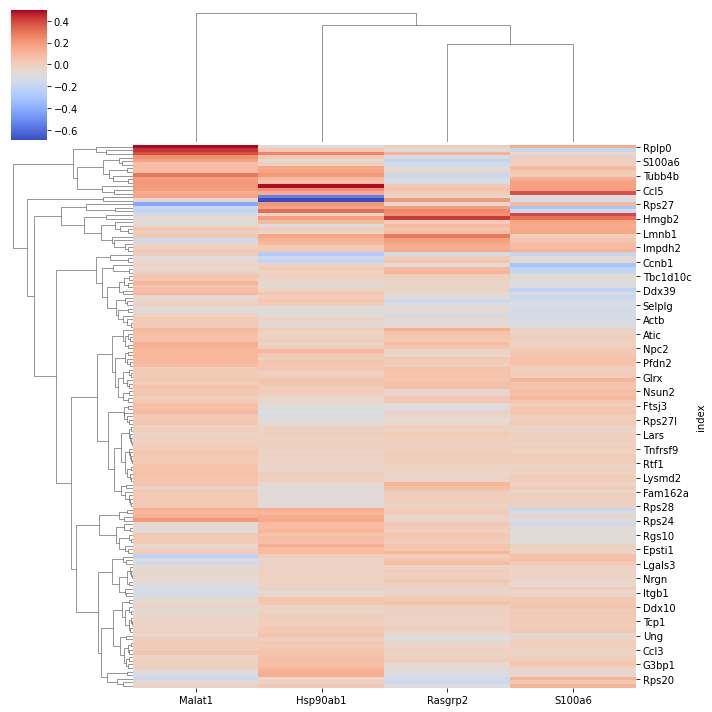

In [25]:
model=LinearRegression()
full = lindf_160
best = best_lindf_160

plotting.cluster_individual(model, best, X_train, y_train, path+'plots/', clustering='ward', lin=True)

In [ ]:
data=lindf_160
index=0

slip = data[[idx for idx in data.columns if idx[1]=='mean_test_neg_mean_squared_error']].iloc[index,:].droplevel(1)
slip[slip>-0.25]

# Linear 1109

In [27]:
# import models
path = './model_selection/vpred/LinearRegression()/'

lin, best_lin = plotting.compile_gridsearches_lin(path, lin = True)

lindf_1109 = pd.DataFrame(plotting.reform(lin))
best_lindf_1109 = pd.DataFrame(best_lin)

/home/ubuntu/miniconda3/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ubuntu/miniconda3/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


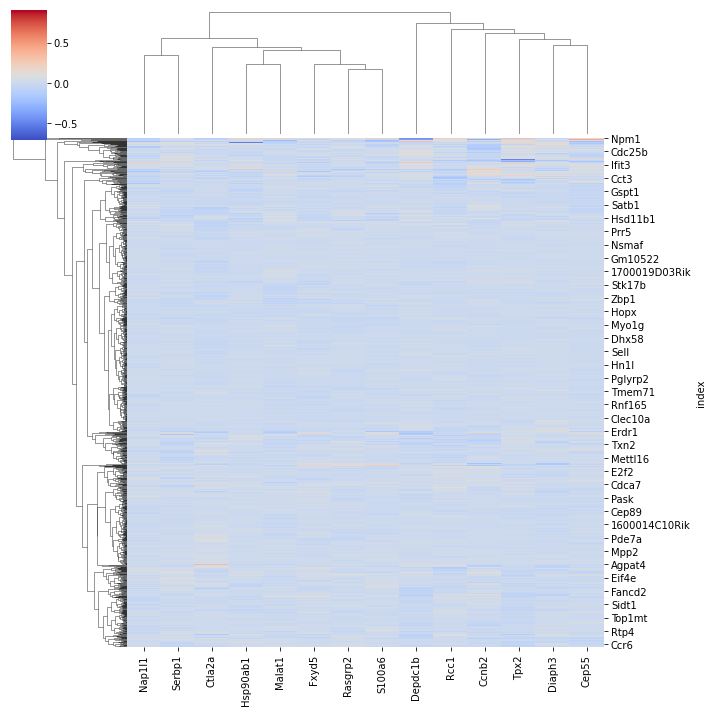

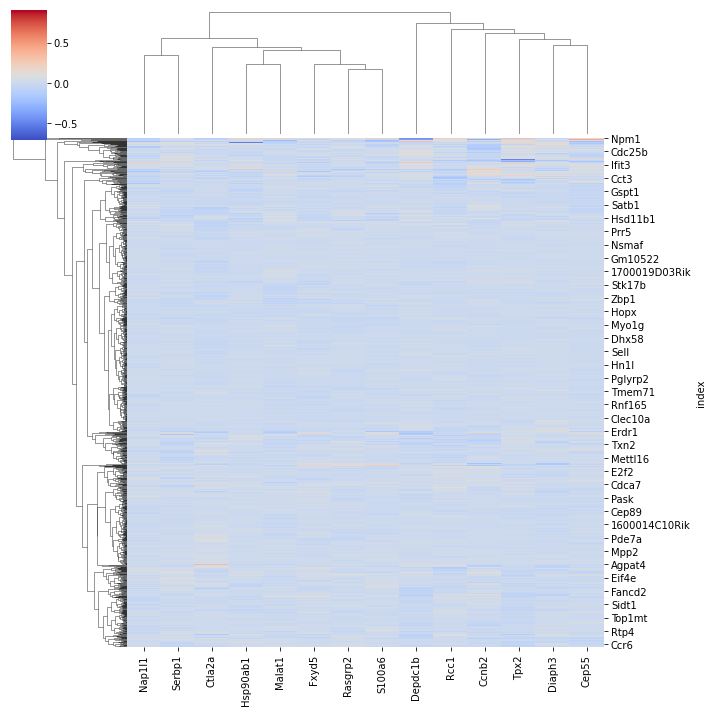

In [28]:
model=LinearRegression()
full = lindf_1109
best = best_lindf_1109

plotting.cluster_individual(model, best, X_train_1109, y_train_1109, path+'plots/', clustering='ward', lin=True)
gridc = plotting.cluster_overall(model, full, X_train_1109, y_train_1109, path+'plots/', clustering='ward', lin=True)

# Table with best R2 and MSE values

In [ ]:
ind = {k:'{} ({})'.format(round(v.loc[evaluate].mean(), 5), round(v.loc[evaluate].std(), 3)) for k, v in data.items()}
ind

In [ ]:
best_lindf_1109==best_lindf_160[best_lindf_1109.columns]

In [ ]:
best_lindf_160

In [ ]:
evaluate ='mean_test_r2'
d = {'Lasso_151':best_ldf_160, 
    'Lasso_1109':best_ldf_1109, 
    'Ridge_151':best_rdf_160, 
    'Ridge_1109':best_rdf_1109,
    'Linear_160': best_lindf_160,
    'Linear_1109': best_lindf_1109}


ind = {k:'{} ({})'.format(round(v.loc[evaluate].mean(), 5), round(v.loc[evaluate].std(), 3)) for k, v in d.items()}
average = {k:'{} ({})'.format(round(v[[idx for idx in v.columns if idx[1]==evaluate]].iloc[plotting.best_overall_index(v),:].droplevel(1).mean(), 5), 
                              round(v[[idx for idx in v.columns if idx[1]==evaluate]].iloc[plotting.best_overall_index(v),:].droplevel(1).std(), 3))
           for k, v in {'Lasso_151':ldf_160, 'Lasso_1109':ldf_1109, 'Ridge_151':rdf_160, 'Ridge_1109':rdf_1109}.items()}

parameter = {k:'{}'.format(round(v.loc[plotting.best_overall_index(v),('Mcm3', 'params')],4)) 
             for k, v in {'Lasso_151':ldf_160, 'Lasso_1109':ldf_1109, 'Ridge_151':rdf_160, 'Ridge_1109':rdf_1109}.items()}



results = pd.DataFrame({'individual': ind, 'average': average, 'parameter': parameter})
results

In [ ]:


ind = {k:'{} ({})'.format(v.loc['mean_train_r2'].mean(), round(v.loc['mean_train_r2'].std(), 3)) for k, v in {'Lasso_151':best_ldf_160, 'Lasso_1109':best_ldf_1109, 'Ridge_151':best_rdf_160, 'Ridge_1109':best_rdf_1109}.items()}
average = {k:v[[idx for idx in v.columns if idx[1]=='mean_train_r2']].iloc[plotting.best_overall_index(v),:].droplevel(1).mean() for k, v in {'Lasso_151':ldf_160, 'Lasso_1109':ldf_1109, 'Ridge_151':rdf_160, 'Ridge_1109':rdf_1109}.items()}


results = pd.DataFrame({'individual': ind, 'average': average})
results

In [ ]:


ind = {k:v.loc['mean_test_neg_mean_squared_error'].mean() for k, v in {'Lasso_151':best_ldf_160, 'Lasso_1109':best_ldf_1109, 'Ridge_151':best_rdf_160, 'Ridge_1109':best_rdf_1109}.items()}
average = {k:v[[idx for idx in v.columns if idx[1]=='mean_test_neg_mean_squared_error']].iloc[plotting.best_overall_index(v),:].droplevel(1).mean() for k, v in {'Lasso_151':ldf_160, 'Lasso_1109':ldf_1109, 'Ridge_151':rdf_160, 'Ridge_1109':rdf_1109}.items()}


results = pd.DataFrame({'individual': ind, 'average': average})
results